# Evaluate DOTA dataset

In [1]:
%matplotlib inline
# %config IPCompleter.greedy=True
import numpy as np
import matplotlib.pyplot as plt

from dotadevkit.misc.DOTA import DOTA
from dotadevkit.misc.DOTA2COCO import DOTA2COCO
from dotadevkit.misc import dota_utils

import pylab

import detectron2
import io
import os
import json
import importlib

import cv2
import random
import torch, torchvision
import PIL

from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import RotatedCOCOEvaluator, DatasetEvaluators, inference_on_dataset, coco_evaluation, DatasetEvaluator
from detectron2.structures import BoxMode

from rotated_detectron_utils import RotatedVisualizer, rotated_mapper, RotatedTrainer, RotatedPredictor, DefaultPredictor
from dota_tools import dota2detectron, wordlist

torch.cuda.set_device(1)

pylab.rcParams['figure.figsize'] = (10.0, 10.0)


dataset_path = '/data2/anne/UIVER/datasets/DOTA'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'val')

# train_path = '/data2/anne/UIVER/datasets/DOTA/dotadevkit/example'

In [2]:
class_name_list = ["small-vehicle", "large-vehicle"]
# class_name_list = ['small-vehicle']

DatasetCatalog.clear()
MetadataCatalog.clear()

MetadataCatalog.get("Train").set(thing_classes=class_name_list) 

namespace(name='Train', thing_classes=['small-vehicle', 'large-vehicle'])

## Check custom mapper

In [3]:
train_catalog = dota2detectron(train_path, False, whitelist=class_name_list)

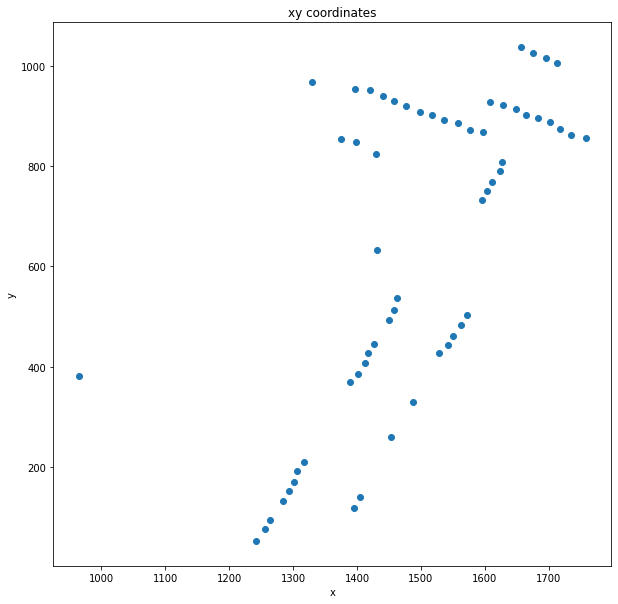

In [16]:
dataset_dict = train_catalog[0]
boxes = np.asarray([anno['bbox'] for anno in dataset_dict['annotations']])
centers = boxes[:,0:2]

plt.scatter(centers[:,0], centers[:,1])
plt.title('xy coordinates')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

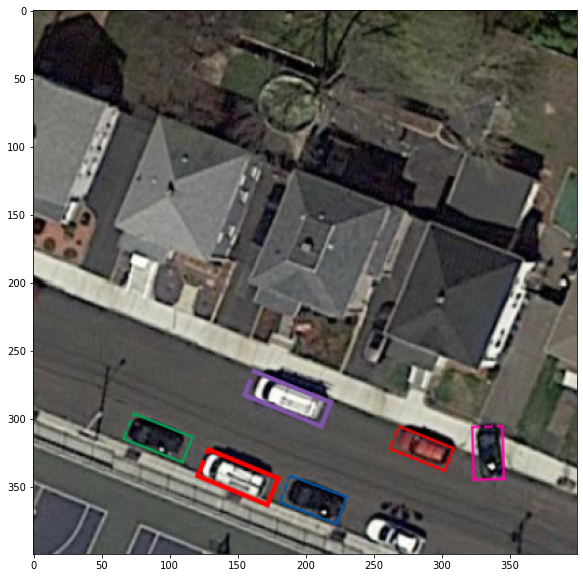

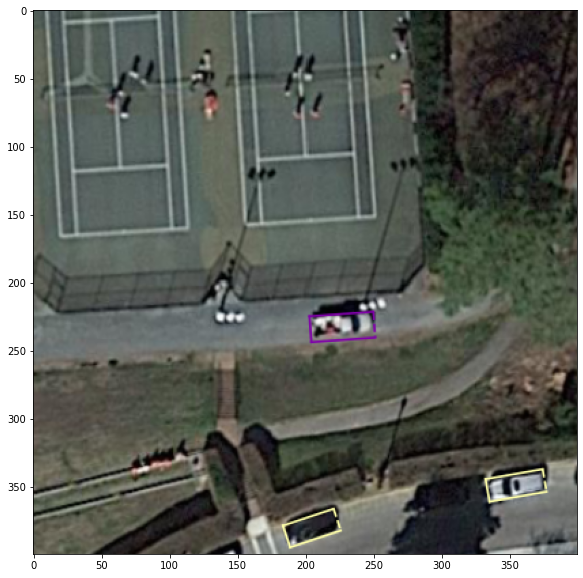

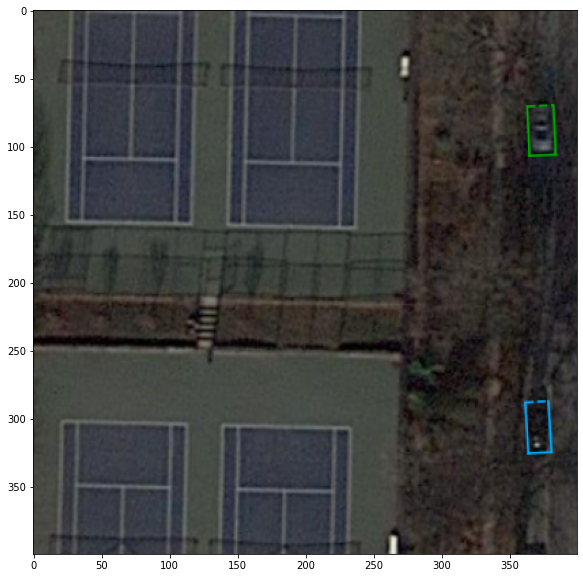

In [4]:
for d in random.sample(train_catalog, 3):
    d = rotated_mapper(d) # apply train augmentations
    # img = cv2.imread(d["file_name"])
    img = d['image'].numpy().transpose(1,2,0)
    visualizer = RotatedVisualizer(img, metadata=MetadataCatalog.get("Train"), scale=1.)
    # out = visualizer.draw_dataset_dict(d)
    out = visualizer.overlay_instances(boxes=d['instances'].gt_boxes)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [3]:
cfg = get_cfg()

cfg.OUTPUT_DIR = os.path.join(dataset_path, 'output_rcnn_small_vehicle')
# cfg.OUTPUT_DIR = os.path.join(dataset_path, 'output_rcnn_small_vehicle_2')

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") # Let training initialize from model zoo
cfg.DATASETS.TRAIN = (["Train"])
cfg.DATASETS.TEST = (["Test"])

cfg.MODEL.MASK_ON=False
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
cfg.MODEL.RPN.HEAD_NAME = "StandardRPNHead"
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ANCHOR_GENERATOR.NAME = "RotatedAnchorGenerator"
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-90,-60,-30,0,30,60,90]]
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 
cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # 512    
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_name_list)
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10,10,5,5,1)
cfg.MODEL.ROI_BOX_HEAD.NUM_CONV=4
cfg.MODEL.ROI_MASK_HEAD.NUM_CONV=8
cfg.SOLVER.IMS_PER_BATCH = 10 # reduce for memory
cfg.SOLVER.CHECKPOINT_PERIOD=1500
cfg.SOLVER.BASE_LR = 0.005
cfg.SOLVER.GAMMA=0.5
cfg.SOLVER.STEPS=[1000,2000,4000,8000, 12000]
cfg.SOLVER.MAX_ITER=14000


cfg.DATALOADER.NUM_WORKERS = 16
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True 
cfg.DATALOADER.SAMPLER_TRAIN= "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD=0.01
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)#lets just check our output dir exists
cfg.MODEL.BACKBONE.FREEZE_AT=6

print(cfg)


CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 16
  REPEAT_THRESHOLD: 0.01
  SAMPLER_TRAIN: RepeatFactorTrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ['Test']
  TRAIN: ['Train']
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, -60, -30, 0, 30, 60, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: RotatedAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 6
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES

In [4]:
test_dict = dota2detectron(test_path, False, whitelist=class_name_list)


In [4]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

predictor = DefaultPredictor(cfg)

for d in random.sample(test_dict, 3):
  # im = cv2.imread(d["file_name"])

  d = rotated_mapper(d) # apply train augmentations
  im = d['image'].numpy().transpose(1,2,0)
  outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
  v = RotatedVisualizer(im,
                  metadata=MetadataCatalog.get("Test"), 
                  scale=0.9)

  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # out = v.draw_dataset_dict(d)
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()
  print(out)



NameError: name 'test_dict' is not defined

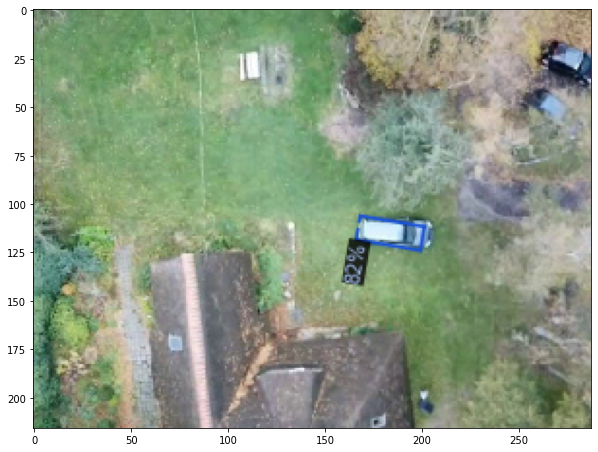

{'instances': Instances(num_instances=1, image_height=240, image_width=320, fields=[pred_boxes: RotatedBoxes(tensor([[204.9149, 128.4156,  13.7737,  37.3096,  80.3325]], device='cuda:1')), scores: tensor([0.8217], device='cuda:1'), pred_classes: tensor([1], device='cuda:1')])}


In [8]:
# test_img = "/data2/anne/UIVER/vehicle_test.jpg"
# test_img = "/data2/anne/UIVER/ortho.jpg"
test_img = "/data2/anne/UIVER/vehicle_scaled.jpg"
# test_img = "/data2/anne/UIVER/src/DOTA/serve/test_image.png"
assert os.path.isfile(test_img)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)


im = cv2.imread(test_img)
im = im[:, :, ::-1]
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = RotatedVisualizer(im[:, :, ::-1],
                metadata=MetadataCatalog.get("Test"), 
                scale=0.9)
                # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
# )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# out = v.draw_dataset_dict(d)
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()
print(outputs)